# MRI Brain Classification Model

### 1. Introduction

This notebook presents an advanced approach to classifying MRI brain scans using deep learning techniques. We leverage state-of-the-art architectures and ensemble methods to achieve high accuracy and robustness. The model pipeline includes data preprocessing, augmentation, model training with hyperparameter optimization, and evaluation using multiple metrics.

```A summary of the work in this notebook can be found here```

[Advancing Brain MRI Image Classification with Deep Learning](https://medium.com/p/17b205075131/edit)

### Style Notebook

In [1]:
from IPython.core.display import HTML

display(HTML('''
<style>
/* General settings */
body {
    font-family: 'Arial', sans-serif;
    line-height: 1.6;
}

/* Code cells */
div.prompt {
    display: none;
}

div.output {
    background-color: #f9f9f9;
    border-radius: 4px;
    padding: 10px;
    margin: 10px 0;
    border: 1px solid #ddd;
}

div.input {
    background-color: #f1f1f1;
    border-radius: 4px;
    padding: 10px;
    margin: 10px 0;
    border: 1px solid #ddd;
}

/* Headers */
h1, h2, h3, h4, h5, h6 {
    text-align: center;
    padding: 10px;
    border-radius: 4px;
    margin-bottom: 20px;
}

h1 {
    color: #2a3f5f;
    background-color: #dbe5f1;
    font-size: 2.5em;
    font-weight: bold;
    border-bottom: 2px solid #2a3f5f;
}

h2 {
    color: #1c2d4d;
    background-color: #c9d6ea;
    font-size: 2em;
    font-weight: bold;
    border-bottom: 1px solid #1c2d4d;
}

h3 {
    color: #0f1b33;
    background-color: #b3c3d9;
    font-size: 1.75em;
    font-weight: bold;
}

h4, h5, h6 {
    color: #0b1426;
    background-color: #a1b3c7;
    font-size: 1.5em;
    font-weight: bold;
}

/* Tables */
table {
    width: 100%;
    border-collapse: collapse;
    margin-bottom: 20px;
}

table, th, td {
    border: 1px solid #dcdcdc;
}

th, td {
    padding: 8px;
    text-align: left;
}

/* Links */
a {
    color: #1c2d4d;
    text-decoration: none;
}

a:hover {
    text-decoration: underline;
}

/* Lists */
ul, ol {
    margin-left: 20px;
}
</style>

'''))


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Importing Libraries


In [4]:
%pip install monai torch torchvision efficientnet-pytorch pydicom transformers tensorflow datasets
%pip install transformers[torch]
%pip install torch-lr-finder
%pip install skorch==0.12.0
%pip install scikit-optimize
%pip install keras
%pip install efficientnet_pytorch
%pip install tensorflow monai
%pip install datasets
%pip install mlflow
%pip install pynrrd
%pip install lmdb
%pip install itk

In [5]:
import os
import random
import numpy as np
import cv2
from PIL import Image
import pydicom
import matplotlib.pyplot as plt

from monai.transforms import (
    Compose, LoadImage, EnsureChannelFirst, ScaleIntensity, CropForeground, RandRotate90,
    RandFlip, RandZoom, ToTensor, RandGaussianNoise, RandAdjustContrast, RandScaleIntensity
)
from monai.data import Dataset, DataLoader
from monai.config import print_config
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.optimizers import Novograd
from monai.inferers import sliding_window_inference
from monai.transforms import Transform

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from efficientnet_pytorch import EfficientNet
from torch.optim.lr_scheduler import StepLR
from transformers import get_linear_schedule_with_warmup
from torch.cuda.amp import GradScaler, autocast
from transformers import SegformerForImageClassification, SegformerFeatureExtractor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Set device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print_config()


ERROR:pydicom.pixels.utils:No module named 'pylibjpeg'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pydicom/pixels/utils.py", line 1274, in _passes_version_check
    module = importlib.import_module(package_name, "__version__")
  File "/usr/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1004, in _find_and_load_unlocked
ModuleNotFoundError: No module named 'pylibjpeg'
ERROR:pydicom.pixels.utils:No module named 'pylibjpeg'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pydicom/pixels/utils.py", line 1274, in _passes_version_check
    module = importlib.import_module(package_name, "__version__")
  File "/usr/lib/python3.10/importlib/__init__.py", line 126, i

MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.4.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.4.0
Nibabel version: 5.0.1
scikit-image version: 0.23.2
scipy version: 1.13.1
Pillow version: 9.4.0
Tensorboard version: 2.17.0
gdown version: 4.7.3
TorchVision version: 0.19.0+cu121
tqdm version: 4.66.5
lmdb version: 1.5.1
psutil version: 5.9.5
pandas version: 2.1.4
einops version: 0.8.0
transformers version: 4.44.2
mlflow version: 2.16.1
pynrrd version: 1.0.0
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



### 3. Data Preprocessing

The raw MRI images are resized and cropped to ensure uniformity in input dimensions, facilitating efficient training and inference. Normalization is applied using the mean and standard deviation of the dataset to standardize the pixel intensity values.


In [6]:
import os
import numpy as np
from PIL import Image
import pydicom
import cv2
from sklearn.preprocessing import LabelEncoder

def load_and_preprocess_images(img_dirs, img_size=(256, 256)):
    images = []
    labels = []
    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

    # Initialize label encoder with the class names
    label_encoder = LabelEncoder()
    label_encoder.fit(class_names)

    for img_dir in img_dirs:
        for class_name in class_names:
            class_dir = os.path.join(img_dir, class_name)
            for root, dirs, files in os.walk(class_dir):
                for file in files:
                    file_path = os.path.join(root, file)
                    img = None

                    if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                        img = Image.open(file_path).convert('RGB')
                        img = img.resize(img_size)
                        img = np.array(img)
                    elif file.endswith('.dcm'):
                        dcm = pydicom.dcmread(file_path)
                        img = dcm.pixel_array
                        img = cv2.resize(img, img_size)
                        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

                    if img is not None:
                        images.append(img)
                        labels.append(class_name)  # Add class name as the label

    if len(images) != len(labels):
        raise ValueError("Number of images and labels do not match.")

    images = np.array(images)
    labels = label_encoder.transform(np.array(labels))  # Transform labels into numeric values

    return images, labels, label_encoder

# Training and testing directories
img_dirs = ['/content/drive/MyDrive/MEDIMG_DIR/Brain_Tumor_MRI_Image_Dataset/Training',
            '/content/drive/MyDrive/MEDIMG_DIR/Brain_Tumor_MRI_Image_Dataset/Testing']

img_size = (256, 256)
images, labels, label_encoder = load_and_preprocess_images(img_dirs, img_size)

print(f'Number of images: {len(images)}')
print(f'Number of labels: {len(labels)}')
print(f'Labels: {list(zip(set(labels), label_encoder.classes_))}')


Number of images: 7023
Number of labels: 7023
Labels: [(0, 'glioma'), (1, 'meningioma'), (2, 'notumor'), (3, 'pituitary')]


### 4. Define Dataset Class

In [7]:
from torch.utils.data import Dataset
import torch

class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if image.dtype != np.uint8:
            image = image.astype(np.uint8)

        # Ensures image has 3 channels
        if image.ndim == 2:
            image = np.stack([image] * 3, axis=-1)
        elif image.shape[2] != 3:
            raise ValueError("Image does not have 3 channels")

        # Permute image to CHW format
        image = torch.tensor(image).permute(2, 0, 1).float()

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label, dtype=torch.long)
        return image, label


### 5. Data Augmentation
Data augmentation is critical in enhancing model generalization by artificially increasing the diversity of the training set. Our augmentation pipeline includes resizing, cropping, random horizontal flipping, random rotation, color jittering, and elastic transformations. These transformations mimic real-world variations and improve the model's robustness.

In [8]:
# Define Data Augmentation
train_transform = Compose([
    ScaleIntensity(),
    RandRotate90(prob=0.5),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(prob=0.5),
    RandGaussianNoise(prob=0.5),
    RandAdjustContrast(prob=0.5),
    RandScaleIntensity(factors=0.1),
    ToTensor()])

val_transform = Compose([
    ScaleIntensity(),
    ToTensor()
])


### 6. Data Splitting
The dataset is split into training, validation, and test sets. The training set is used to train the model, the validation set is used to tune hyperparameters and avoid overfitting, and the test set is used for final evaluation.

- Training set: 70%
- Validation set: 15%
- Test set: 15%

Batch image shape: torch.Size([16, 3, 256, 256])
Batch label shape: torch.Size([16])
Batch labels: tensor([1, 0, 2, 3, 1, 0, 1, 1, 3, 2, 2, 3, 3, 1, 3, 2])


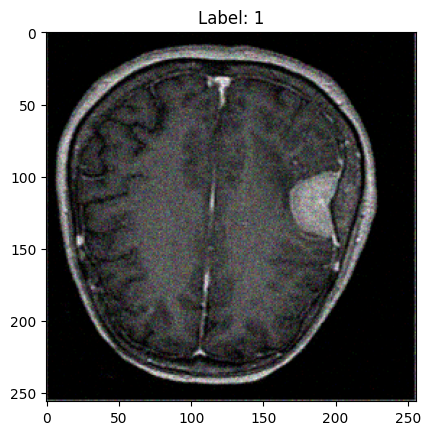

Class mapping: {0: 0, 1: 1, 2: 2, 3: 3}
Train loader size: 4916
Validation loader size: 1053
Test loader size: 1054


In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Load images and labels
images, labels, label_encoder = load_and_preprocess_images(img_dirs, img_size)

# Split the dataset into training, validation, and test sets
train_images, temp_images, train_labels, temp_labels = train_test_split(images, labels, test_size=0.3, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.5, random_state=42)

def create_dataloader(images, labels, batch_size, transform):
    dataset = ImageDataset(images, labels, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

initial_batch_size = 16
batch_size = initial_batch_size

while True:
    try:
        train_loader = create_dataloader(train_images, train_labels, batch_size, train_transform)
        val_loader = create_dataloader(val_images, val_labels, batch_size, val_transform)
        test_loader = create_dataloader(test_images, test_labels, batch_size, val_transform)
        break
    except RuntimeError as e:
        if 'out of memory' in str(e):
            batch_size = batch_size // 2
            torch.cuda.empty_cache()
            print(f"Reducing batch size to {batch_size} due to memory constraints.")
        else:
            raise e

# Example printout to verify label distribution
batch = next(iter(train_loader))
batch_images, batch_labels = batch
print(f'Batch image shape: {batch_images.shape}')
print(f'Batch label shape: {batch_labels.shape}')
print(f'Batch labels: {batch_labels}')


# Display the first image and its label
img = batch_images[0].permute(1, 2, 0).cpu().numpy()
img = np.clip(img, 0, 1)
label = batch_labels[0].cpu().numpy()
plt.imshow(img, cmap='gray')
plt.title(f'Label: {label}')
plt.show()

# Need to get class mappings
num_classes = len(set(labels))
class_mapping = {i: label for i, label in enumerate(set(labels))}
print(f'Class mapping: {class_mapping}')

# Verify the sizes of the datasets
print(f'Train loader size: {len(train_loader.dataset)}')
print(f'Validation loader size: {len(val_loader.dataset)}')
print(f'Test loader size: {len(test_loader.dataset)}')


### 7. Define Model

EfficientNet is a family of convolutional neural networks that scales up the model's depth, width, and resolution in a systematic manner. This model achieves state-of-the-art accuracy while being computationally efficient.

$EfficientNet
B0
​
 →EfficientNet
B7
​
$



In [10]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

class EfficientNetCustom(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.6):
        super(EfficientNetCustom, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b3')
        num_ftrs = self.model._fc.in_features

        # Custom fully connected head
        self.model._fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, num_ftrs // 2),
            nn.BatchNorm1d(num_ftrs // 2),  # Keep BatchNorm in FP32
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs // 2, num_classes)
        )

    def forward(self, x):
        # Extract features and ensure the model runs properly with FP16/FP32
        with torch.amp.autocast(device_type='cuda'):
            x = self.model.extract_features(x)
            x = self.model._avg_pooling(x)
            x = x.flatten(start_dim=1)

        # Force FP32 for sensitive operations like BatchNorm
        x = x.to(torch.float32)
        x = self.model._fc(x)  # Apply the custom FC layer
        return x

# Initialize the model as before
model = EfficientNetCustom(num_classes=num_classes, dropout_rate=0.6)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:01<00:00, 44.1MB/s]

Loaded pretrained weights for efficientnet-b3


### 8. Loss Function with Label Smoothing

Label smoothing is employed to mitigate the effects of overfitting by preventing the model from becoming overly confident in its predictions. This technique distributes part of the probability mass to all classes, reducing the model's confidence in any single class prediction.

The loss function can be expressed as:

$\text{Loss} = \alpha \cdot \text{NLL\_Loss} + (1 - \alpha) \cdot \text{Smooth\_Loss}
\alpha = 1.0 - \text{smoothing}$

In [11]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, preds, target):
        confidence = 1.0 - self.smoothing
        log_preds = torch.log_softmax(preds, dim=-1)
        nll_loss = -log_preds.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -log_preds.mean(dim=-1)
        loss = confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

criterion = LabelSmoothingCrossEntropy(smoothing=0.1)


In [12]:
def extract_data_from_loader(loader):
    data = []
    labels = []
    for inputs, targets in loader:
        data.append(inputs)
        labels.append(targets)
    data = torch.cat(data)
    labels = torch.cat(labels)
    return data, labels

# Extract data and labels
X_train, y_train = extract_data_from_loader(train_loader)
X_val, y_val = extract_data_from_loader(val_loader)

# Verify shapes
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')


X_train shape: torch.Size([4916, 3, 256, 256]), y_train shape: torch.Size([4916])
X_val shape: torch.Size([1053, 3, 256, 256]), y_val shape: torch.Size([1053])


### 9. Learning Rate Finder

To achieve the optimal learning rate for the model, we will implore the LRFinder from the Torch library.

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 55.4MB/s]


Loaded pretrained weights for efficientnet-b0


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.70E-04


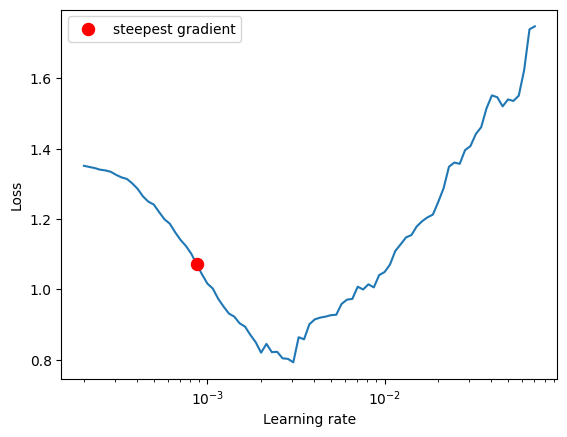

In [13]:
#!pip install efficientnet_pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch_lr_finder import LRFinder
from efficientnet_pytorch import EfficientNet

# Define the get_classification_model function
def get_classification_model(num_classes):
    """
    Returns a classification model, in this case, an EfficientNet.
    """
    model = EfficientNet.from_pretrained('efficientnet-b0')
    num_ftrs = model._fc.in_features
    model._fc = nn.Linear(num_ftrs, num_classes)
    return model

def find_optimal_lr(model, train_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
    lr_finder.range_test(train_loader, end_lr=1e-1, num_iter=100)
    lr_finder.plot()
    lr_finder.reset()

num_classes = len(set(labels))
model = get_classification_model(num_classes) # Now this should work
find_optimal_lr(model, train_loader)

In [14]:
# Example optimal learning rate found from the range test
optimal_lr = 1e-4
print(f'Optimal learning rate: {optimal_lr}')

# Define the optimizer and scheduler function
def get_optimizer_and_scheduler(model, dataloader, num_epochs, warmup_steps):
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, min_lr=1e-6)
    return optimizer, scheduler


Optimal learning rate: 0.0001


### 10. Model Training Function

The model is trained using the training set, with validation performed at each epoch to monitor performance and avoid overfitting. Early stopping is used to halt training if no improvement is observed for a specified number of epochs.

In [15]:
import torch
import torch.nn as nn

def train_classification_model_with_accumulation(model, train_loader, val_loader, num_epochs, accumulation_steps, patience=7):
    criterion = nn.CrossEntropyLoss()
    optimizer, scheduler = get_optimizer_and_scheduler(model.to(device), train_loader, num_epochs, warmup_steps=100)
    scaler = torch.amp.GradScaler(device='cuda')
    best_val_loss = float('inf')
    best_model_wts = None
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        optimizer.zero_grad()
        torch.cuda.empty_cache()

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Updated autocast context manager
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()  # Save the best model weights
            epochs_no_improve = 0
            print(f'Validation loss improved to {val_loss:.4f}. Saving model weights.')
        else:
            epochs_no_improve += 1
            print(f'No improvement in validation loss for {epochs_no_improve} consecutive epochs.')

        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch+1} due to no improvement in validation loss for {patience} consecutive epochs.')
            break

    # Load best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model.to(device)


### 11. Train Model

In [16]:
# Define the number of accumulation steps to simulate larger batch size
accumulation_steps = 4
num_epochs = 20
num_classes = len(label_encoder.classes_)

# Initialize the model
model = EfficientNetCustom(num_classes=num_classes, dropout_rate=0.6)
trained_model = train_classification_model_with_accumulation(model, train_loader, val_loader, num_epochs, accumulation_steps)

#trained_model.to('cpu')

Loaded pretrained weights for efficientnet-b3
Epoch 1/20, Loss: 0.9912
Validation Loss: 0.4959, Accuracy: 87.18%
Validation loss improved to 0.4959. Saving model weights.
Epoch 2/20, Loss: 0.4772
Validation Loss: 0.1961, Accuracy: 93.26%
Validation loss improved to 0.1961. Saving model weights.
Epoch 3/20, Loss: 0.3260
Validation Loss: 0.1200, Accuracy: 96.11%
Validation loss improved to 0.1200. Saving model weights.
Epoch 4/20, Loss: 0.2682
Validation Loss: 0.0923, Accuracy: 97.44%
Validation loss improved to 0.0923. Saving model weights.
Epoch 5/20, Loss: 0.2406
Validation Loss: 0.0823, Accuracy: 97.82%
Validation loss improved to 0.0823. Saving model weights.
Epoch 6/20, Loss: 0.2073
Validation Loss: 0.0733, Accuracy: 97.44%
Validation loss improved to 0.0733. Saving model weights.
Epoch 7/20, Loss: 0.1650
Validation Loss: 0.0617, Accuracy: 98.20%
Validation loss improved to 0.0617. Saving model weights.
Epoch 8/20, Loss: 0.1459
Validation Loss: 0.0460, Accuracy: 98.67%
Validation l

### 12. Model Evaluation


We evaluate the model using multiple metrics to gain a comprehensive understanding of its performance. In addition to accuracy, we compute the F1 score and ROC-AUC to assess the model's precision, recall, and overall discriminative ability.

**Accuracy**: $\text{Acc} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
$

**F1 Score**:$
F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$

**ROC-AUC**:
$\text{ROC-AUC}$


In [18]:
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize


def evaluate_model(model, test_loader, label_encoder):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_probs = []
    all_labels = []
    criterion = nn.CrossEntropyLoss()
    num_classes = len(label_encoder.classes_)

    # Ensure the model is on the appropriate device
    model = model.to(device)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Mixed precision evaluation with autocast
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(inputs)  # Ensure this handles FP16 properly
                loss = criterion(outputs, labels)

            # Ensure loss is in FP32 to avoid precision mismatches
            running_loss += loss.item() * inputs.size(0)

            # Get the predictions and softmax probabilities
            _, predicted = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()

            # Accumulate the total number of correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store the predicted and actual labels
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    # Calculate final test loss and accuracy
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = 100 * correct / total

    # Calculate F1 Score and ROC-AUC
    f1_score_value = f1_score(all_labels, all_preds, average='weighted')
    roc_auc_value = roc_auc_score(label_binarize(all_labels, classes=np.arange(num_classes)), np.array(all_probs), average='macro')

    # Classification report and confusion matrix
    class_report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Compute ROC curve and ROC-AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(label_binarize(all_labels, classes=np.arange(num_classes))[:, i], np.array(all_probs)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Per-class accuracy and overall accuracy
    accuracy_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1) * 100
    overall_accuracy = np.mean(accuracy_per_class)
    mean_roc_auc = np.mean(list(roc_auc.values()))

    # Output evaluation results
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%, F1 Score: {f1_score_value:.4f}, ROC-AUC: {roc_auc_value:.4f}')
    print("\n=== Classification Report ===")
    print(class_report)

    print("\n=== Confusion Matrix ===")
    for row in conf_matrix:
        print(row)

    print("\n=== ROC-AUC Scores ===")
    for i in range(num_classes):
        print(f"Class {label_encoder.classes_[i]}: ROC-AUC = {roc_auc[i]:.2f}")
    print(f"Macro Average ROC-AUC = {mean_roc_auc:.2f}")

    print("\n=== Accuracy per Class ===")
    for i, acc in enumerate(accuracy_per_class):
        print(f"Class {label_encoder.classes_[i]}: Accuracy = {acc:.2f}%")

    print("\n=== Overall Metrics ===")
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")
    print(f"Mean ROC-AUC: {mean_roc_auc:.2f}")

    return test_loss, test_acc, f1_score_value, roc_auc_value, class_report, conf_matrix, accuracy_per_class, overall_accuracy, mean_roc_auc, all_labels, all_probs

# Assuming `test_loader`, `label_encoder`, and `trained_model` are defined
results = evaluate_model(trained_model, test_loader, label_encoder)

# Unpack the results if needed
(test_loss, test_acc, f1_score_value, roc_auc_value, class_report, conf_matrix,
 accuracy_per_class, overall_accuracy, mean_roc_auc, true_labels, all_probs) = results


Test Loss: 0.0407, Test Accuracy: 99.15%, F1 Score: 0.9915, ROC-AUC: 0.9992

=== Classification Report ===
              precision    recall  f1-score   support

      glioma       0.98      1.00      0.99       239
  meningioma       1.00      0.99      0.99       266
     notumor       1.00      0.99      1.00       286
   pituitary       0.99      0.98      0.99       263

    accuracy                           0.99      1054
   macro avg       0.99      0.99      0.99      1054
weighted avg       0.99      0.99      0.99      1054


=== Confusion Matrix ===
[238   0   0   1]
[  1 264   0   1]
[  1   0 284   1]
[  3   1   0 259]

=== ROC-AUC Scores ===
Class glioma: ROC-AUC = 1.00
Class meningioma: ROC-AUC = 1.00
Class notumor: ROC-AUC = 1.00
Class pituitary: ROC-AUC = 1.00
Macro Average ROC-AUC = 1.00

=== Accuracy per Class ===
Class glioma: Accuracy = 99.58%
Class meningioma: Accuracy = 99.25%
Class notumor: Accuracy = 99.30%
Class pituitary: Accuracy = 98.48%

=== Overall Metric

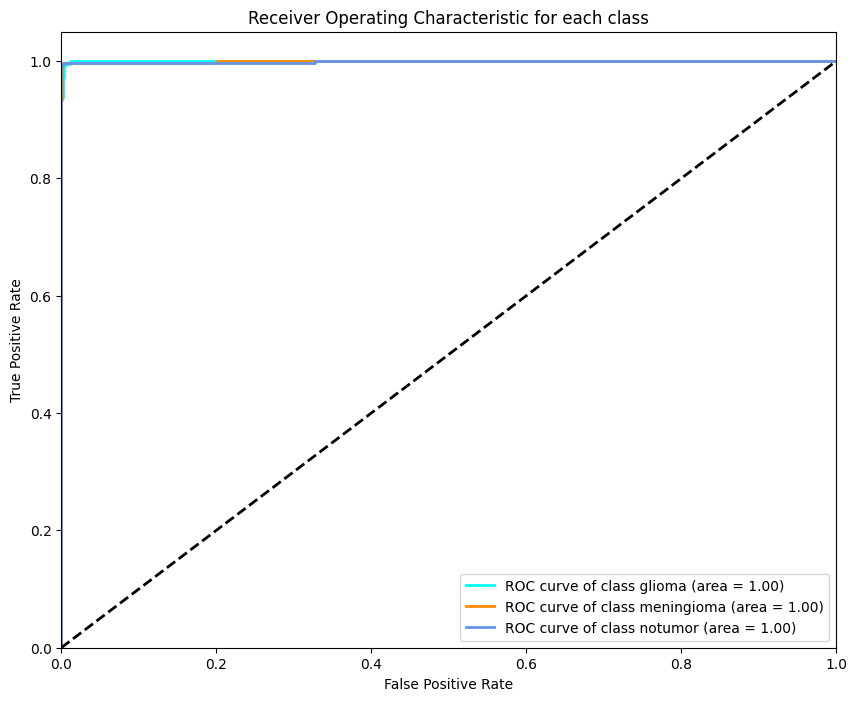

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for ROC curve plotting
true_labels_binarized = label_binarize(true_labels, classes=np.arange(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], np.array(all_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


### 13. Pruning and Quantization

In [ ]:
import torch.nn.utils.prune as prune

# Example: Prune the final fully connected layer of EfficientNet
def prune_model(model, amount=0.4):
    # Prune 40% of the connections in the final fully connected layer
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):  # Only prune Linear layers
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')  # Optional: remove the mask and apply pruning permanently
    return model

# Apply pruning
trained_model = prune_model(trained_model)

In [ ]:
# Apply dynamic quantization to the Linear and LSTM layers
def apply_dynamic_quantization(model):
    quantized_model = torch.quantization.quantize_dynamic(
        model, {nn.Linear}, dtype=torch.qint8
    )
    return quantized_model

# Apply dynamic quantization
quantized_model = apply_dynamic_quantization(trained_model)
quantized_model.to(device)

In [ ]:
pruned_model = prune_model(trained_model, amount=0.4)

# Quantize the pruned model
quantized_pruned_model = apply_dynamic_quantization(pruned_model)

# Move the quantized pruned model to the device
quantized_pruned_model.to(device)

In [ ]:
# Evaluate the pruned and quantized model
results = evaluate_model(quantized_pruned_model, test_loader, label_encoder)

# Unpack results
(test_loss, test_acc, f1_score_value, roc_auc_value, class_report, conf_matrix,
 accuracy_per_class, overall_accuracy, mean_roc_auc, true_labels, all_probs) = results

### 14. Get Predictions

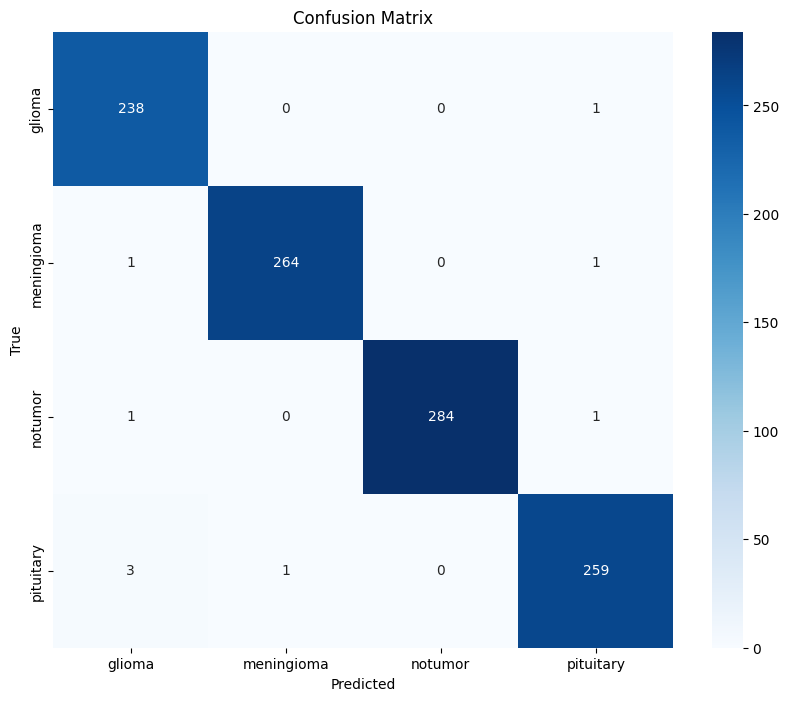

Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      1.00      0.99       239
  meningioma       1.00      0.99      0.99       266
     notumor       1.00      0.99      1.00       286
   pituitary       0.99      0.98      0.99       263

    accuracy                           0.99      1054
   macro avg       0.99      0.99      0.99      1054
weighted avg       0.99      0.99      0.99      1054



In [20]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

# Get predictions on the test set
true_labels, predicted_labels = get_predictions(trained_model, test_loader)

# Decode labels to original class names
true_labels_decoded = label_encoder.inverse_transform(true_labels)
predicted_labels_decoded = label_encoder.inverse_transform(predicted_labels)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels_decoded, predicted_labels_decoded, labels=label_encoder.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(true_labels_decoded, predicted_labels_decoded, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_report)



### 15. Visualize Predictions

In [22]:
def prepare_image(image):
    if image.ndim == 2:
        image = np.stack([image] * 3, axis=-1)
    elif image.shape[2] != 3:
        raise ValueError("Image does not have 3 channels")

    # Normalize image
    if image.max() > 1:
        image = image / 255.0

    return image

def create_dataloader(images, labels, batch_size, transform):
    dataset = MedicalImageDataset(images, labels, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)


In [23]:
def get_predictions_and_labels(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

# Get predictions and labels
true_labels, predicted_labels = get_predictions_and_labels(trained_model, test_loader)


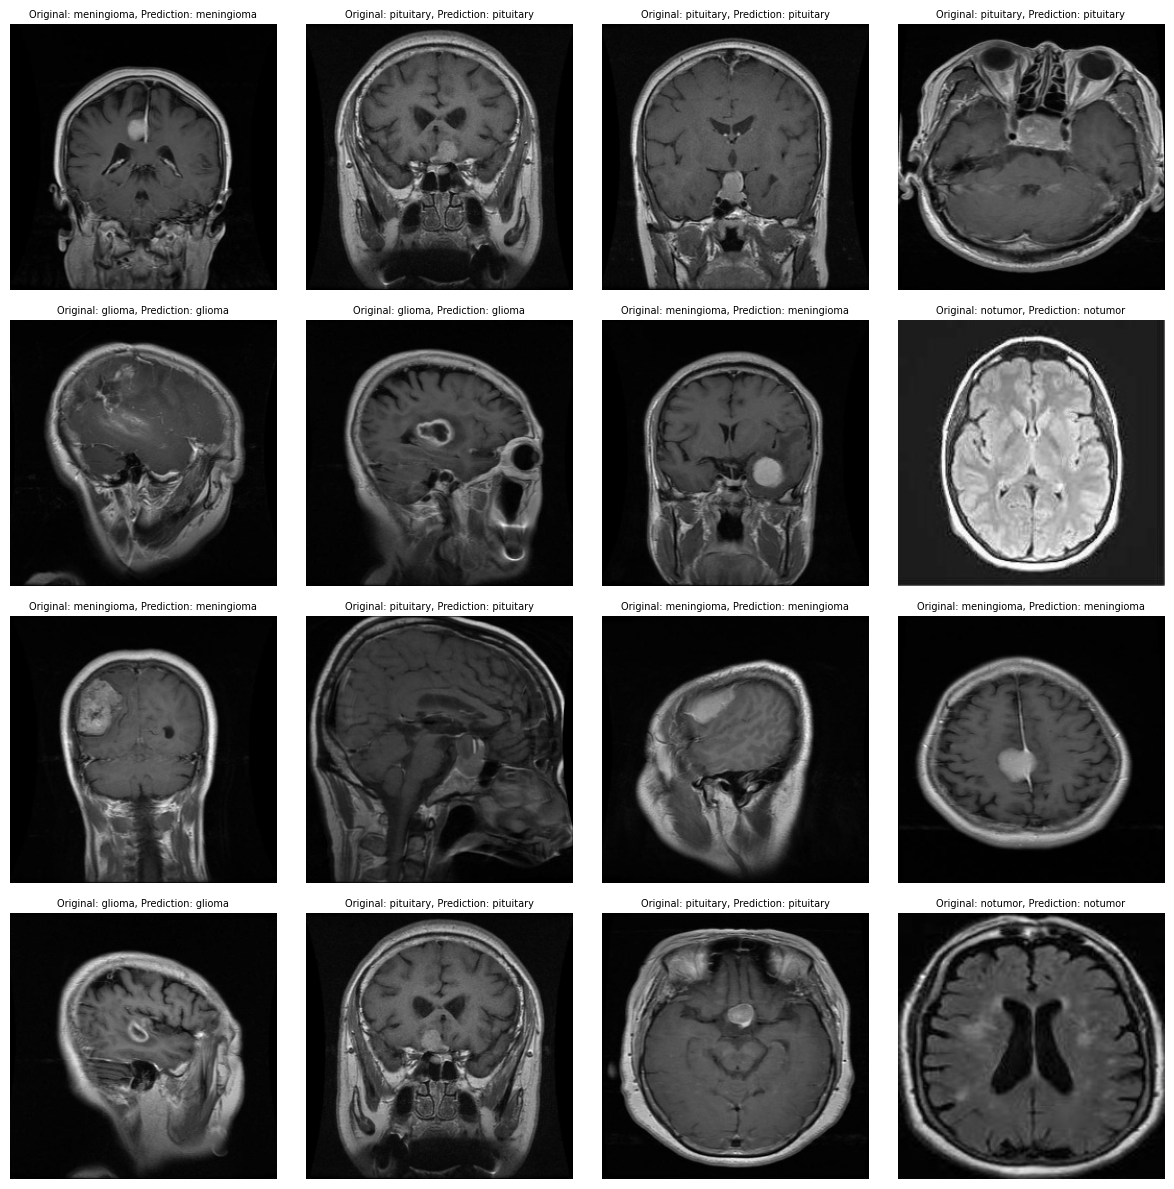

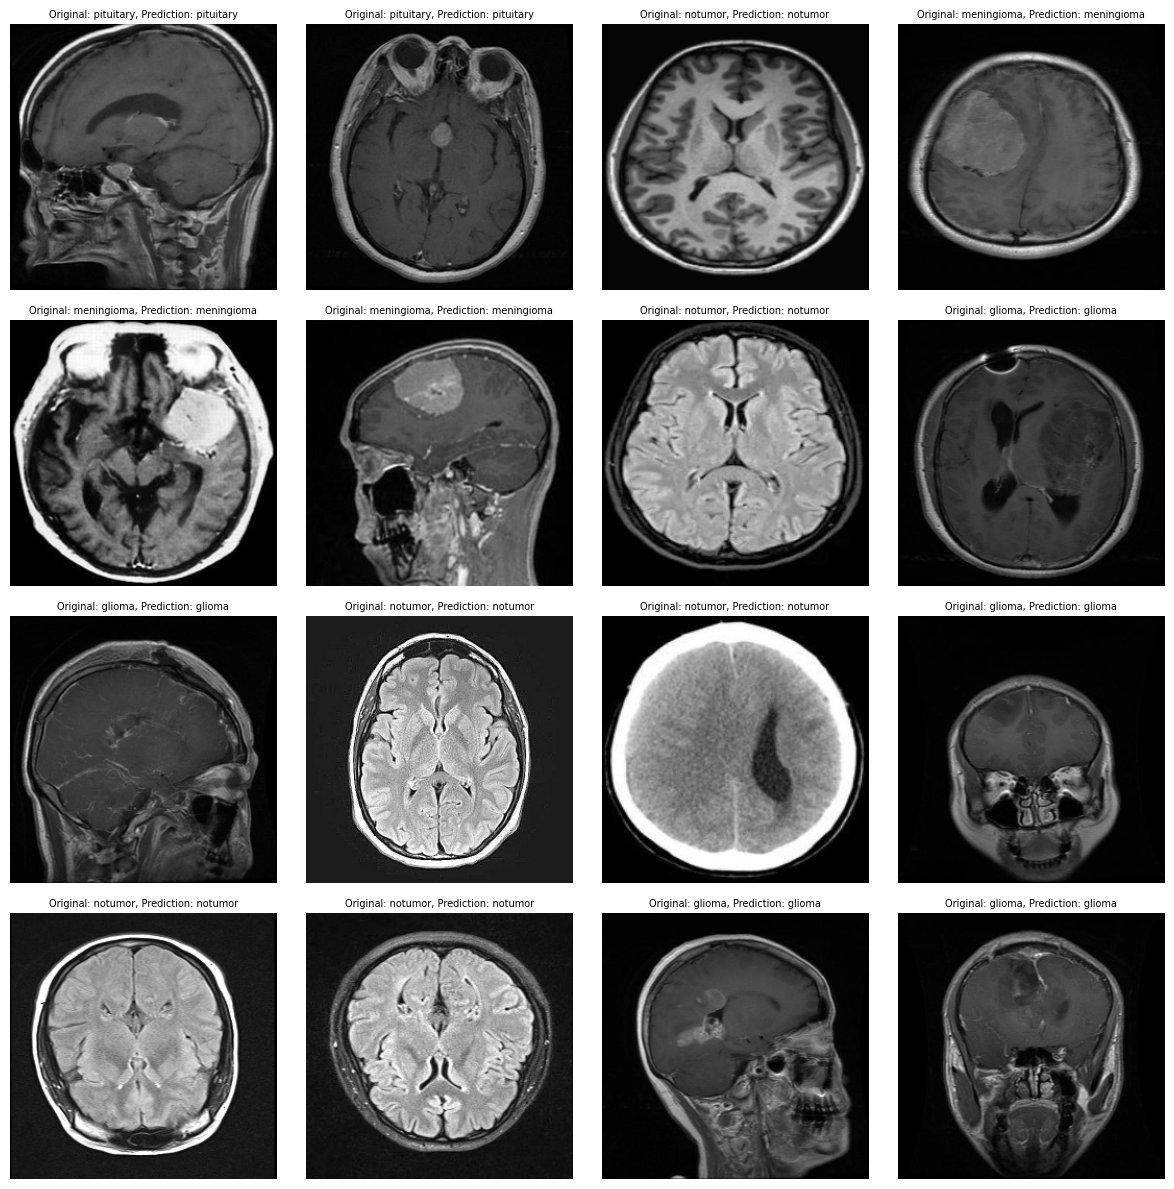

In [24]:
def visualize_predictions_grid(images, true_labels, predictions, grid_size=(4, 4), title_fontsize=7):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 12))
    axes = axes.flatten()

    for img, true_label, pred, ax in zip(images, true_labels, predictions, axes):
        img = prepare_image(img)  # Ensure proper formatting for the image
        ax.imshow(img)
        # Set the title to include both the original and predicted labels
        title = f'Original: {true_label}, Prediction: {pred}'
        ax.set_title(title, fontsize=title_fontsize, pad=5)
        ax.axis('off')

    # Turn off axes for remaining plots in case there are fewer images than grid spaces
    for i in range(len(images), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def predict_and_visualize_grid(model, dataloader, label_encoder, grid_size=(4, 4), samples_per_class=7):
    model.eval()
    images, true_labels, predictions = [], [], []  # Include true labels
    class_samples = {label: 0 for label in label_encoder.classes_}
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if total_samples >= 267:  # Stop when you reach a total of 267 samples
                    break

                image = inputs[i].cpu().numpy().transpose(1, 2, 0)  # Convert from tensor to numpy
                prediction = label_encoder.inverse_transform([predicted[i].cpu().numpy()])[0]
                true_label = label_encoder.inverse_transform([labels[i].cpu().numpy()])[0]

                # Ensure that you sample the correct number of images per class
                if class_samples[true_label] < samples_per_class:
                    images.append(image)
                    true_labels.append(true_label)  # Store true labels
                    predictions.append(prediction)
                    class_samples[true_label] += 1
                    total_samples += 1

                # Display grid if enough samples are collected
                if len(images) == grid_size[0] * grid_size[1]:
                    visualize_predictions_grid(images, true_labels, predictions, grid_size)  # Pass true_labels and predictions
                    images, true_labels, predictions = [], [], []  # Reset after displaying

        # Display any remaining images that didn't fill the last grid
        if len(images) > 0:
            visualize_predictions_grid(images, true_labels, predictions, grid_size)  # Pass true_labels and predictions

# Example usage
predict_and_visualize_grid(trained_model, test_loader, label_encoder, grid_size=(4, 4), samples_per_class=8)


### 16. Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold

def cross_val_train(images, labels, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(images, labels)):
        print(f"Starting fold {fold + 1}/{n_splits}")

        train_images, val_images = images[train_idx], images[val_idx]
        train_labels, val_labels = labels[train_idx], labels[val_idx]

        train_dataset = ImageDataset(train_images, train_labels, transform=train_transform)
        val_dataset = ImageDataset(val_images, val_labels, transform=val_transform)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = EfficientNetCustom(num_classes=len(set(labels)), dropout_rate=0.6).to(device)
        trained_model = train_classification_model_with_accumulation(model, train_loader, val_loader, num_epochs=10, accumulation_steps=4, patience=7)

        val_preds = []
        val_targets = []

        # Evaluate the model on the validation set
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = trained_model(inputs)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())

        accuracy = accuracy_score(val_targets, val_preds)
        accuracies.append(accuracy)
        print(f'Fold {fold + 1} Accuracy: {accuracy:.4f}')
        print("=====================================================")

    mean_accuracy = np.mean(accuracies)
    print(f'Cross-Validation Mean Accuracy: {mean_accuracy:.4f}')
    print('Cross-Validation Completed Successfully')

labels = np.array(labels)
cross_val_train(images, labels)


### 17. Grad-CAM Visualization

Loaded pretrained weights for efficientnet-b3


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


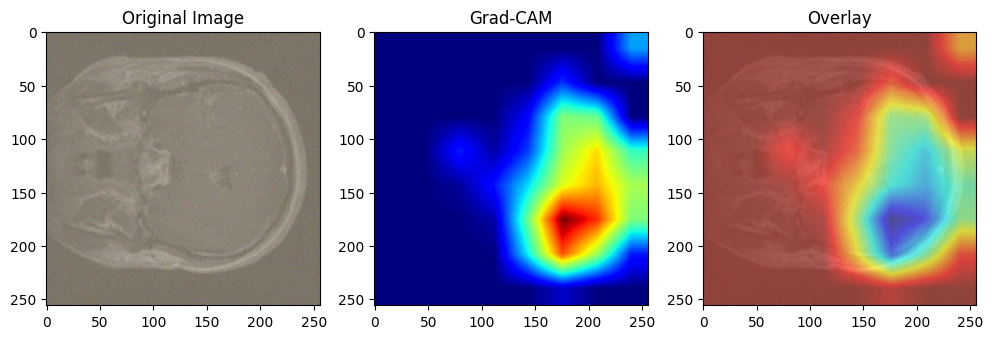

In [26]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hooks = []

        # Register hooks for forward and backward passes
        self.hooks.append(self.target_layer.register_forward_hook(self.save_activations))
        self.hooks.append(self.target_layer.register_backward_hook(self.save_gradients))

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, input_image, target_class):
        self.model.zero_grad()
        output = self.model(input_image)
        loss = output[0, target_class]
        loss.backward()

        gradients = self.gradients.data.cpu().numpy()
        activations = self.activations.data.cpu().numpy()

        # Improved gradient weighting by normalizing across spatial dimensions
        weights = np.mean(gradients, axis=(2, 3))[0, :]
        cam = np.zeros(activations.shape[2:], dtype=np.float32)

        # Weighted sum of activations using the gradients as weights
        for i, w in enumerate(weights):
            cam += w * activations[0, i, :, :]

        # Apply ReLU to remove negative values
        cam = np.maximum(cam, 0)

        # Normalize the CAM to (0,1)
        cam = cam - np.min(cam)
        if np.max(cam) != 0:
            cam = cam / np.max(cam)

        # Resize CAM to match the input image size
        cam = cv2.resize(cam, (input_image.shape[2], input_image.shape[3]))

        return cam

    def release(self):
        for hook in self.hooks:
            hook.remove()

def visualize_gradcam(image_tensor, model, target_class, target_layer):
    grad_cam = GradCAM(model, target_layer)
    cam = grad_cam(image_tensor, target_class)
    grad_cam.release()

    # Convert tensor to numpy array and denormalize for display
    image = image_tensor.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image = np.clip(image, 0, 1)

    # Display heatmap and original image
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # Improved overlay with better scaling
    overlay = heatmap + np.float32(image)
    overlay = overlay / np.max(overlay)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap='jet')
    plt.title("Grad-CAM")
    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.show()

# Test Grad-CAM on EfficientNet model using the uploaded image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientNetCustom(num_classes=4).to(device)
model.eval()

# Visualize Grad-CAM on a batch from train_loader
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        break

# Detach from no_grad context to calculate gradients
images.requires_grad = True

# Visualize Grad-CAM for the uploaded image
target_layer = model.model._blocks[-2]  # The last block of EfficientNet
target_class = 0  # Assuming class 07for demonstration, you can replace it with the actual target class
visualize_gradcam(images[0].unsqueeze(0), model, target_class, target_layer)


In [27]:
import numpy as np

def gradcam_metrics(cam):

    # Initialize metrics dictionary
    metrics = {}

    # Flatten the CAM to calculate metrics
    flat_cam = cam.flatten()

    # Maximum intensity
    metrics['max_intensity'] = np.max(flat_cam)

    # Mean intensity
    metrics['mean_intensity'] = np.mean(flat_cam)

    # Standard deviation of intensity
    metrics['std_intensity'] = np.std(flat_cam)

    # Activated area ratio
    threshold = 0.5
    activated_area = np.sum(flat_cam > threshold)
    total_area = flat_cam.size
    metrics['activated_area_ratio'] = activated_area / total_area

    return metrics


# Visualize Grad-CAM for first image
target_layer = model.model._blocks[-1]
target_class = labels[0].item()

# Obtain the Grad-CAM heatmap
grad_cam = GradCAM(model, target_layer)
cam = grad_cam(images[0].unsqueeze(0), target_class)
grad_cam.release()

# Calculate metrics
metrics = gradcam_metrics(cam)
print("Grad-CAM Metrics:", metrics)

print("\nInterpretation of Grad-CAM Metrics:")
print(f"1. **Max Intensity**: {metrics['max_intensity']}")
print("   - Indicates the highest activation in the heatmap. A high value suggests a strong focus on specific features in the image.")

print(f"2. **Mean Intensity**: {metrics['mean_intensity']}")
print("   - Provides an average measure of the activations across the heatmap. It reflects the overall level of activation.")

print(f"3. **Standard Deviation of Intensity**: {metrics['std_intensity']}")
print("   - Shows the variation in activation levels across the heatmap. A higher value indicates greater variation, suggesting that certain areas are much more activated than others.")

print(f"4. **Activated Area Ratio**: {metrics['activated_area_ratio'] * 100:.2f}%")
print("   - Represents the proportion of the image that has significant activation (above a threshold of 0.5). A higher ratio means a larger area of the image is considered important by the model.")


Grad-CAM Metrics: {'max_intensity': 1.0, 'mean_intensity': 0.16465473, 'std_intensity': 0.256225, 'activated_area_ratio': 0.1562652587890625}

Interpretation of Grad-CAM Metrics:
1. **Max Intensity**: 1.0
   - Indicates the highest activation in the heatmap. A high value suggests a strong focus on specific features in the image.
2. **Mean Intensity**: 0.16465473175048828
   - Provides an average measure of the activations across the heatmap. It reflects the overall level of activation.
3. **Standard Deviation of Intensity**: 0.25622498989105225
   - Shows the variation in activation levels across the heatmap. A higher value indicates greater variation, suggesting that certain areas are much more activated than others.
4. **Activated Area Ratio**: 15.63%
   - Represents the proportion of the image that has significant activation (above a threshold of 0.5). A higher ratio means a larger area of the image is considered important by the model.


### 18. Save the Model

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'model.pth', _use_new_zipfile_serialization=False)

# Load the model
device = torch.device('cpu')
model = EfficientNetCustom(num_classes=4)
model.load_state_dict(torch.load('model.pth', map_location=device))
model.to(device)

model_path = '/content/drive/MyDrive/MEDIMG_DIR/effnet_b3_model_best.pth'
torch.save(trained_model.state_dict(), model_path)
print(f'Model saved to {model_path}')
